# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../.."))

In [2]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch
import torchvision
import numpy
import timm
import pandas
import optuna
from copy import deepcopy
from cluster import train, confusion, execute, epochs, SelectedGPUs
from PIL import Image
from itertools import product

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8

FontLibrary.Fonts.GraphTitle.FontSize = 10

FigureWidthHeight = (6.69291, 10.1181-1.0)

In [4]:
device = torch.device(2 if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Подготовка модели и данных

In [5]:
# Предпочтительные параметры
size = 2.0E-6
near_N = 8000 #2004 #1336
near_length = 16.0E-3
wavelength = 500.0E-9
distance = 50.0E-3
masks_amount = 1

# Параметры обучения
batch_size = 32//8
epochs_count = 10

# Вычисляемые параметры
pixels = closest_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = closest_integer(length*cppp / size)

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")
print(f"Размер батча:                             {batch_size}")
print(f"Кол-во эпох:                              {epochs_count}")
print(f"Отношения пикселя к длине волны:          {round(length/(N*wavelength))}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       8000
Количество пикселей маски:                8000
Размер оптических элементов:              16.0 мм
Размер пикселя маски:                     2.0 мкм
Расстояние между слоями:                  50.0 мм
Размер батча:                             4
Кол-во эпох:                              10
Отношения пикселя к длине волны:          4


In [6]:
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
elements = [propagation]
for phase_modulator, amplitude_modulator in zip(phase_modulators, amplitude_modulators):
    elements += [phase_modulator, amplitude_modulator, propagation]
spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((length/50, length/50), (0,0))
detectors = ClassificationDetectors(N, length, wavelength, 10, detectors_filter, spectral_filter)
elements.append(detectors)
model = CompositeModel(*elements)
dataset = Dataset('MNIST', batch_size, N, N, torch.float32, threads=8, preload=10)

# Тренировка модели

In [7]:
mh, lh, cmh = [], [], []
torch.cuda.empty_cache()
mh, lh, cmh = epochs(epochs_count, 10, model, dataset, MseCrossEntropyCombination(0.3), torch.optim.Adam, lr=0.001)
# from pickle import load
# with open("../../../cluster/cash/checkpoints.pkl", 'rb') as file:
#     data = load(file)
# mh, lh, cmh = data
# print(len(cmh))
# print(f"Accuracy is {100 * numpy.sum(numpy.diagonal(cmh[-1], 0)) / numpy.sum(cmh[-1])}")
# print(mh[-1].element(0).pixels.input.x)

Training main thread PID is: 2490925
100%|███████████████████████████████████████| 1875/1875 [19:34<00:00,  1.60it/s]
Accuracy in the beginning is 11.481666666666667
RL:59.518, RPI1K:-235.17: 100%|███████████████████ | 1875/1875 | 20:45m - 00:00m
100%|███████████████████████████████████████| 1875/1875 [19:49<00:00,  1.58it/s]
Accuracy after epoch 1 is 83.28666666666666
RL:37.465, RPI1K:-5.47: 100%|█████████████████████ | 1875/1875 | 20:21m - 00:00m
100%|███████████████████████████████████████| 1875/1875 [18:58<00:00,  1.65it/s]
Accuracy after epoch 2 is 86.8
RL:23.727, RPI1K:-2.27: 100%|█████████████████████ | 1875/1875 | 20:21m - 00:00m
100%|███████████████████████████████████████| 1875/1875 [19:06<00:00,  1.64it/s]
Accuracy after epoch 3 is 88.19833333333334
RL:14.996, RPI1K:-1.42: 100%|█████████████████████ | 1875/1875 | 20:19m - 00:00m
100%|███████████████████████████████████████| 1875/1875 [19:32<00:00,  1.60it/s]
Accuracy after epoch 4 is 90.04166666666667
RL:11.628, RPI1K:-1.06:

# Результаты

In [21]:
model = mh[-2]
loss_history = numpy.stack(lh)[0]
confusion_matrix = cmh[-1]

In [22]:
torch.cuda.empty_cache()
examples = 1
examples_images = next(iter(Dataset('MNIST', examples, N, N, torch.float32).test))[0].to(device)
model.to(device)
with torch.no_grad():
    examples_optical_results = model.forward(examples_images, elements=masks_amount*3).cpu()
    examples_detectors_results = detectors.forward(examples_optical_results).cpu()
model.cpu()
examples_images = examples_images.cpu()
torch.cuda.empty_cache()

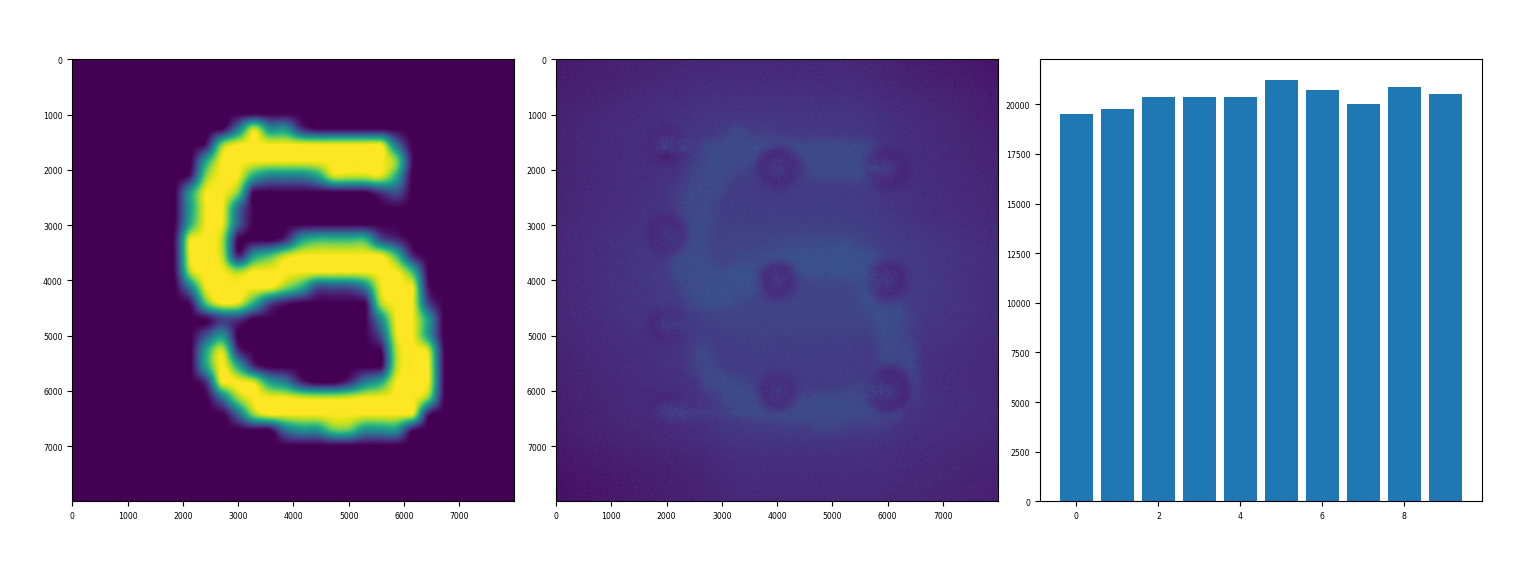

In [23]:
plot = TiledPlot(15,60)
plot.FontLibrary = FontLibrary

for row, (image, optical, detector) in enumerate(zip(examples_images, examples_optical_results, examples_detectors_results)):
    axes = plot.axes.add(0,row)
    axes.imshow(image[0], aspect='auto')

    axes = plot.axes.add(1,row)
    axes.imshow(optical[0].abs(), aspect='auto')

    axes = plot.axes.add(2,row)
    axes.bar(numpy.arange(10), detector)
plot.show()

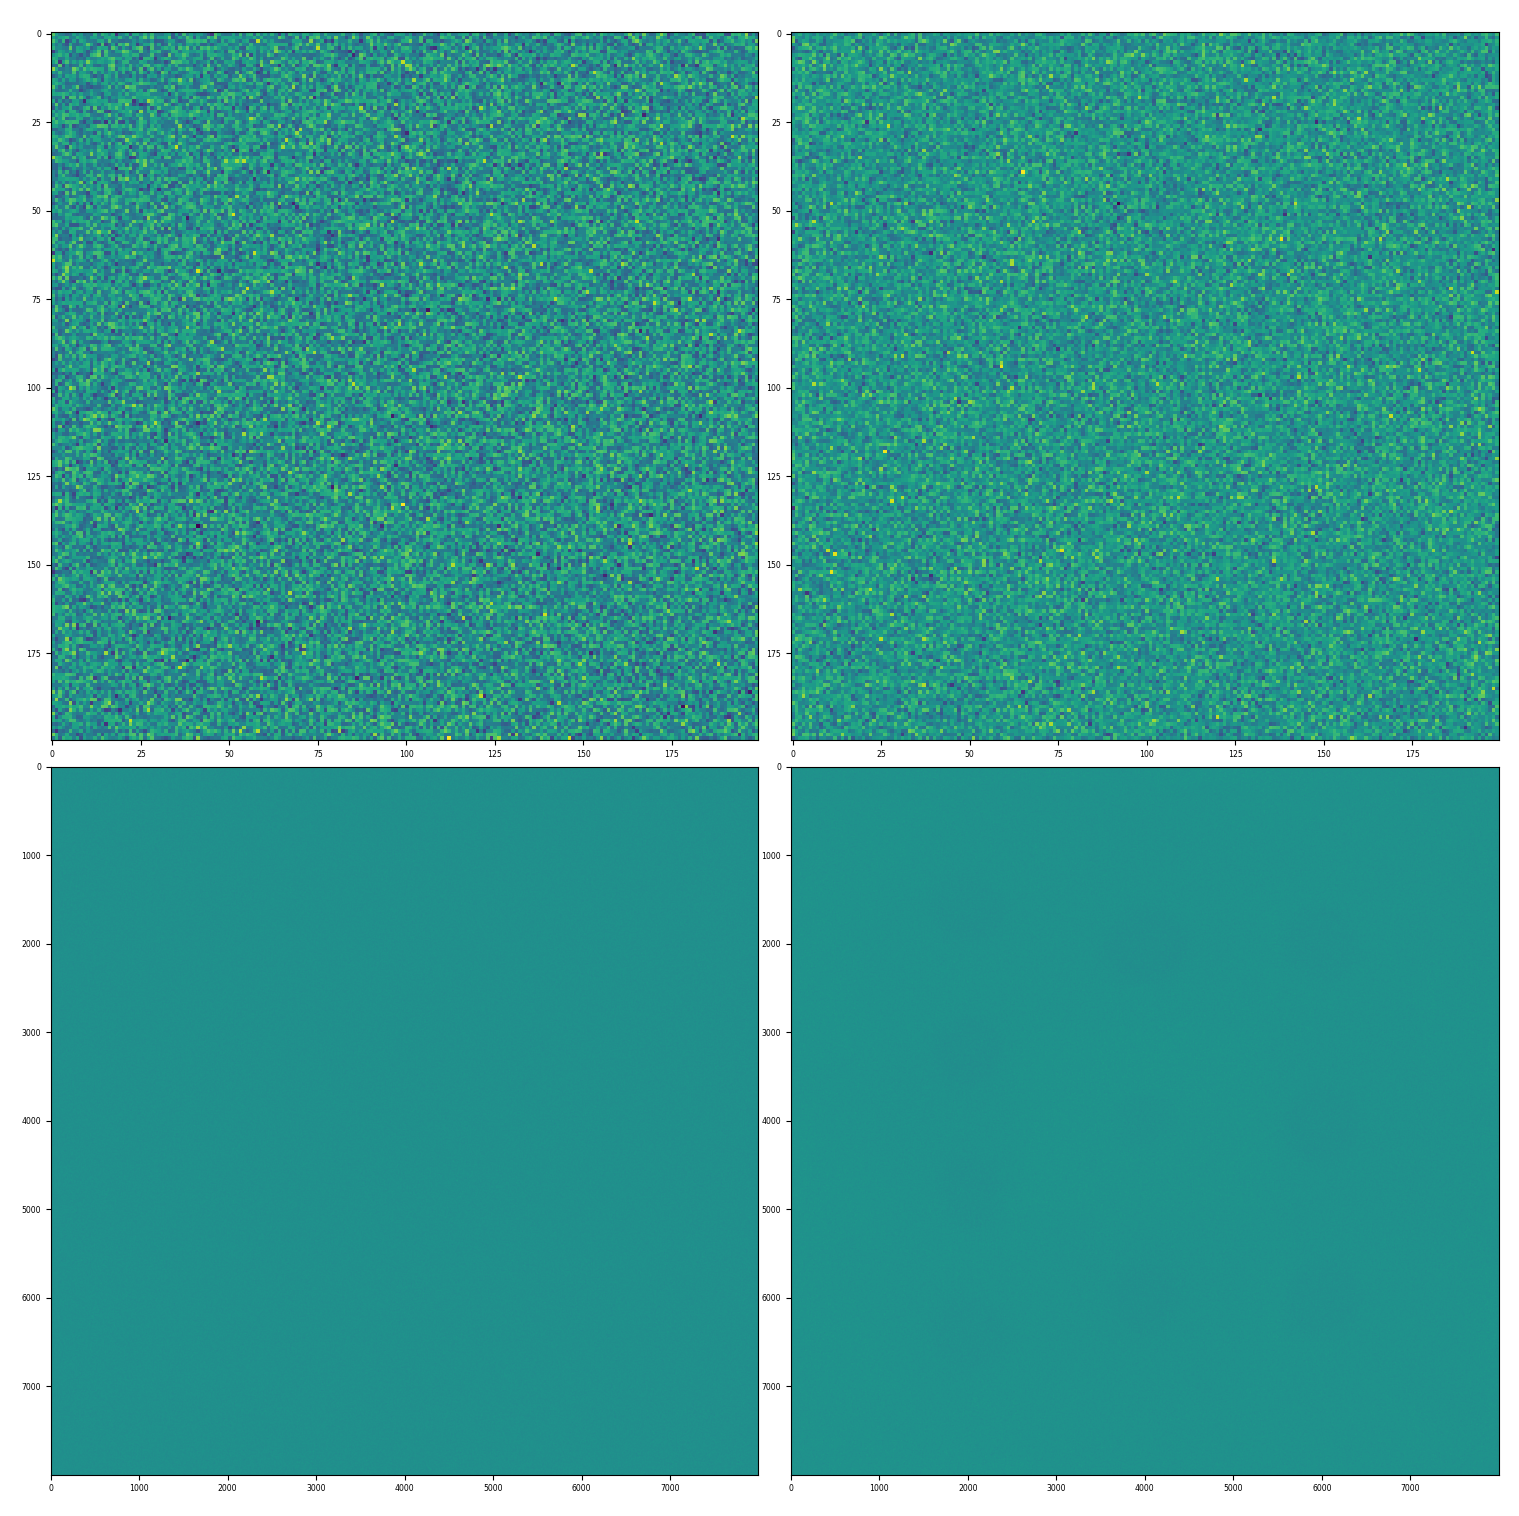

In [24]:
plot = TiledPlot(15,15)
plot.FontLibrary = FontLibrary
axes = plot.axes.add(0,0)
axes.imshow(model.element(1).properties[pixels//2-100:-pixels//2+100, pixels//2-100:-pixels//2+100], aspect='auto')
axes = plot.axes.add(1,0)
axes.imshow(model.element(2).properties[pixels//2-100:-pixels//2+100, pixels//2-100:-pixels//2+100], aspect='auto')
axes = plot.axes.add(0,1)
axes.imshow(model.element(1).properties, aspect='auto')
axes = plot.axes.add(1,1)
axes.imshow(model.element(2).properties, aspect='auto')
plot.show()

# Тренировка с помощью Optuna

In [12]:
# def objective(trial:optuna.trial):
#     propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
#     phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
#     amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
#     elements = [propagation]
#     for phase_modulator, amplitude_modulator in zip(phase_modulators, amplitude_modulators):
#         elements += [phase_modulator, amplitude_modulator, propagation]
#     spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
#     detectors_filter = Gaussian((length/10, length/10), (0,0))
#     detectors = ClassificationDetectors(N, length, wavelength, 10, detectors_filter, spectral_filter)
#     elements.append(detectors)
#     model = CompositeModel(*elements)
#     dataset = Dataset('MNIST', batch_size, N, N, torch.float32, threads=8, preload=10)

    